In [1]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=5)

trainer = CenterGuidanceTrainer(path=gaussian_path, model=model1, p_uncond=0.1,model_type="FM", centers=[torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])])

trainer.train_loop(num_epochs=10000, device=device, lr=1e-3, n= 2000)

In Epoch 0 we have a loss of 54.92825698852539
In Epoch 1000 we have a loss of 4.919161796569824
In Epoch 2000 we have a loss of 4.217007160186768
In Epoch 3000 we have a loss of 3.9951443672180176
In Epoch 4000 we have a loss of 4.2682414054870605
In Epoch 5000 we have a loss of 4.21793270111084
In Epoch 6000 we have a loss of 3.9495034217834473
In Epoch 7000 we have a loss of 3.4570932388305664
In Epoch 8000 we have a loss of 3.7194769382476807
In Epoch 9000 we have a loss of 3.66080641746521


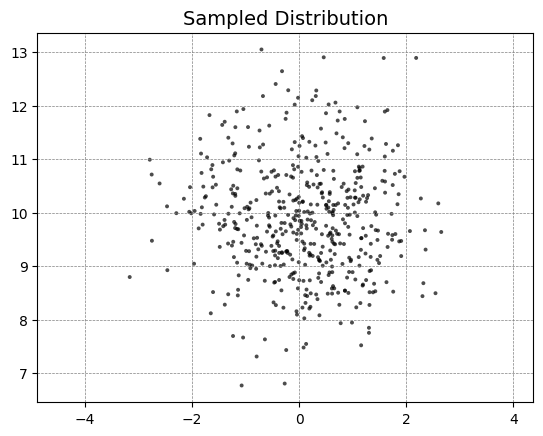

In [3]:
ode = GuidedVectorField(model1, guidance_scale=1, null_index=4)
solver = EulerODESolver(ode)
sampler = Sampler(solver)

steps = torch.linspace(0.01, 1, 500).view(1, -1, 1).expand(500, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(500)

condition_index = 2
y_index = torch.full((gaussian_samples.shape[0],), fill_value=condition_index, dtype=torch.long, device=device)

final_samples = sampler.sample_without_traj(gaussian_samples, steps, y_index = y_index)

plot_samples(final_samples)
plt.show()

Lets look at the diffusion case for guidance

In [4]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=5)

trainer = CenterGuidanceTrainer(path=gaussian_path, model=model1, p_uncond=0.1,model_type="Diffusion", centers=[torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])])

trainer.train_loop(num_epochs=10000, device=device, lr=1e-3, n= 2000)

In Epoch 0 we have a loss of 8.561464309692383
In Epoch 1000 we have a loss of 17.142852783203125
In Epoch 2000 we have a loss of 23.76869010925293
In Epoch 3000 we have a loss of 7.963598728179932
In Epoch 4000 we have a loss of 4.749864101409912
In Epoch 5000 we have a loss of 8.187076568603516
In Epoch 6000 we have a loss of 8.596900939941406
In Epoch 7000 we have a loss of 14.941767692565918
In Epoch 8000 we have a loss of 12.068382263183594
In Epoch 9000 we have a loss of 208.947021484375


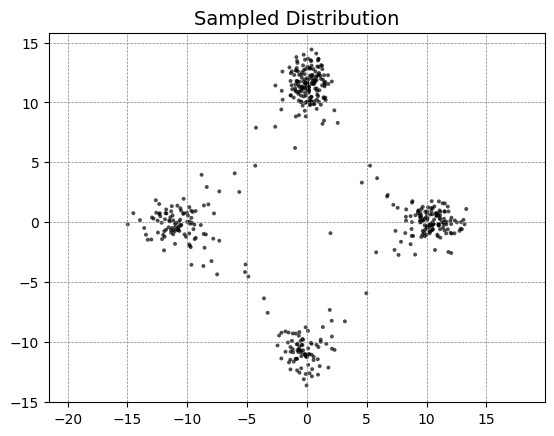

In [7]:
sde = ProductGuidanceLangevin([model1], alpha=LinearAlpha(), beta=SquareRootBeta(), sigma=1.0, guidance_scales=[10], null_index=trainer.null_index)
sdesolver = EulerSDESolver(sde)
sdesampler = Sampler(sdesolver)

steps = torch.linspace(0.01, 1, 500).view(1, -1, 1).expand(500, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(500)



condition_index1 = 0
y_index1 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index1, dtype=torch.long, device=device)

condition_index2 = 3
y_index2 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index2, dtype=torch.long, device=device)

indicies = [y_index1]

final_samples = sdesampler.sample_without_traj(gaussian_samples, steps, y_index = indicies)

plot_samples(final_samples)
plt.show()